In [1]:
import pandas as pd
from pandas import Series,DataFrame

"""
IMPORTANT NOTE: If parsing Excel files fails, conda install xlrd AND openpyxl
"""

# BLS dataset for labor participation
bls_file = pd.ExcelFile('staadata.xlsx')
# Parse the first sheet of the excel file and set as DataFrame
header = ['FIPS Code', 'State', 'Year', 'Civilian non-institutional population',
           'Civilian labor force Total', 'CLF Percent of population', 'CLF Employment Total',
           'CLF Employment Percent of population', 'CLF Unemployment Total',
           'CLF Unemployment Rate'
          ]
bls = bls_file.parse('Sheet1', skiprows=7, names=header)
bls12 = bls[bls.Year == 2012]
bls12 = bls12[['State','CLF Employment Percent of population','CLF Unemployment Rate']]
bls12['CLF Employment Percent of population'] = pd.to_numeric(bls12['CLF Employment Percent of population'])
bls12['CLF Unemployment Rate'] = pd.to_numeric(bls12['CLF Unemployment Rate'])
bls12.set_index('State')

# 2012 Election data to determine if a state is "red" or "blue"
pres_file = pd.ExcelFile('2012pres.xls')
pres = pres_file.parse('2012 Pres General Results')
pres = pres.drop([1, 'FEC ID', 'STATE ABBREVIATION', 'GENERAL ELECTION DATE'], axis=1)
Dem = pres[pres['LAST NAME'] == 'Obama'].set_index('STATE')
Rep = pres[pres['LAST NAME'] == 'Romney'].set_index('STATE')
Dem_Rep = pd.DataFrame(Dem['GENERAL %'] - Rep['GENERAL %'])
Dem_Rep.rename(columns={'GENERAL %': 'PercentDemocratHasOverRepublican'}, inplace=True)
Dem_Rep.reset_index(level=0, inplace=True)

# Load income per capita as response variable
income = pd.read_csv('per_capita_income.csv', low_memory=False)
income = income[[1, 2]]
income.set_index('State')

# Merge data sets
data = pd.merge(Dem_Rep, income, left_on='STATE', right_on='State')
data = pd.merge(data, bls12).drop(['STATE'], axis=1).set_index('State')
data.columns = ['PercentObamaOverRomney', 'IncomePerCapita',
                'Labor Participation', 'Unemployment_2012']
data['PercentObamaOverRomney'] = pd.to_numeric(data['PercentObamaOverRomney'])
data['IncomePerCapita'] = data['IncomePerCapita'].apply(lambda x: x.replace('$', '').replace(',', ''))
data['IncomePerCapita'] = pd.to_numeric(data['IncomePerCapita'])
data['Labor Participation'] = pd.to_numeric(data['Labor Participation'])
data['Unemployment_2012'] = pd.to_numeric(data['Unemployment_2012'])
data['PercentObamaOverRomney_center'] = data['PercentObamaOverRomney'] - 0.005563
data.head()

,PercentObamaOverRomney,IncomePerCapita,Labor Participation,Unemployment_2012,PercentObamaOverRomney_center
State,,,,,
Alabama,-0.221868,23606,53.4,8.0,-0.227431
Alaska,-0.139889,33062,63.4,7.1,-0.145452
Arizona,-0.090648,25715,55.5,8.3,-0.096211
Arkansas,-0.236879,22883,54.8,7.6,-0.242442
California,0.231186,30441,56.6,10.4,0.225623


In [2]:
data.describe()

,PercentObamaOverRomney,IncomePerCapita,Labor Participation,Unemployment_2012,PercentObamaOverRomney_center
count,53.000000,53.000000,53.000000,53.000000,5.300000e+01
mean,0.005563,28949.132075,59.673585,7.415094,-2.994887e-07
std,0.234447,4803.792720,4.428281,1.692790,2.344470e-01
min,-0.480409,21036.000000,50.200000,3.100000,-4.859717e-01
25%,-0.172071,25615.000000,56.400000,6.000000,-1.776341e-01
50%,0.029793,27870.000000,59.100000,7.500000,2.423033e-02
75%,0.152879,32357.000000,63.100000,8.500000,1.473157e-01
max,0.836348,45877.000000,70.800000,11.200000,8.307852e-01


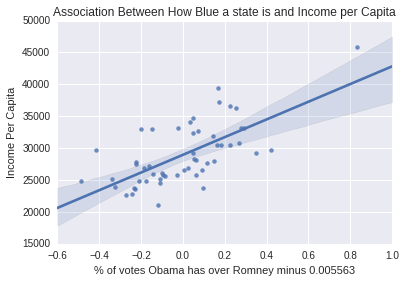

In [3]:
# -2.994887e-07 is practically 0 for our purpose
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
scat1 = seaborn.regplot(x="PercentObamaOverRomney_center", y="IncomePerCapita", scatter=True, data=data)
plt.xlabel('% of votes Obama has over Romney minus 0.005563')
plt.ylabel('Income Per Capita')
plt.title('Association Between How Blue a state is and Income per Capita')
plt.show()

In [4]:
import statsmodels.formula.api as smf
print ("OLS regression model for the Association between how Blue a state is and Income per Capita")
reg1 = smf.ols('PercentObamaOverRomney_center ~ IncomePerCapita', data=data).fit()
print (reg1.summary())

OLS regression model for the Association between how Blue a state is and Income per Capita
                                  OLS Regression Results                                 
Dep. Variable:     PercentObamaOverRomney_center   R-squared:                       0.459
Model:                                       OLS   Adj. R-squared:                  0.448
Method:                            Least Squares   F-statistic:                     43.22
Date:                           Sun, 14 Aug 2016   Prob (F-statistic):           2.56e-08
Time:                                   12:26:40   Log-Likelihood:                 18.445
No. Observations:                             53   AIC:                            -32.89
Df Residuals:                                 51   BIC:                            -28.95
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
         